# Лабораторная работ №1

## 1.	Реализовать Фильтр коэффициентов (Quotient filter).

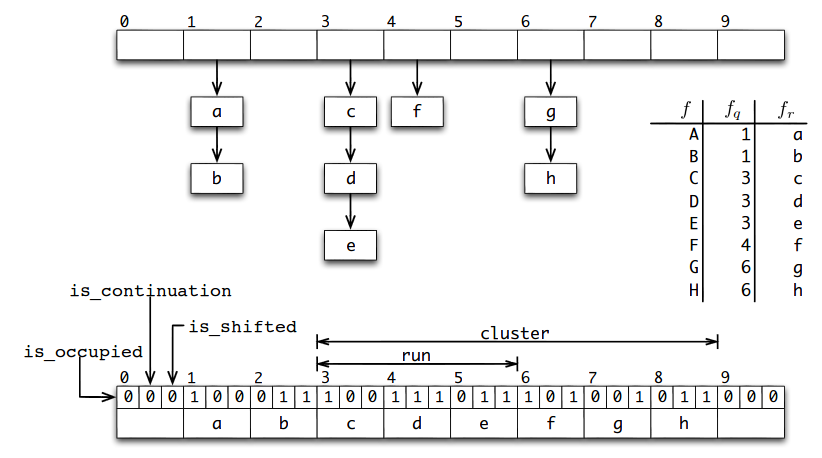

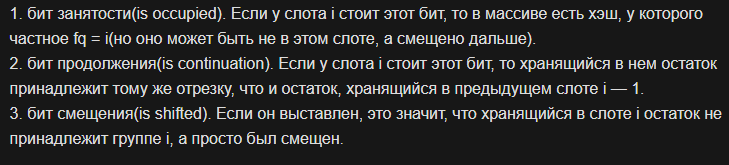

In [ ]:
import mmh3
import random
import matplotlib.pyplot as plt

class QuotientFilter:
    def __init__(self, q, r):
        self.q = q
        self.r = r
        self.size = 1 << q  # 2^q
        self.table = [None] * self.size
        self.metadata = [0] * self.size  # 3 бита: [is_occupied, is_continuation, is_shifted]
        self.count = 0
    
    def _hash(self, x):
        h = mmh3.hash(str(x)) & ((1 << (self.q + self.r)) - 1)
        quotient = h >> self.r
        remainder = h & ((1 << self.r) - 1)
        return quotient, remainder
    
    def insert(self, x):
        q, rem = self._hash(x)
        
        # Если элемент уже существует, ничего не делаем
        if self.query_without_hash(x, q, rem):
            return True
            
        # Проверяем, есть ли место
        if self.count >= self.size * 0.95:  # Оставляем 5% свободного места
            return False  # Фильтр почти полон
            
        run_start = self._find_run_start(q)
        pos = q
        
        while True:
            if self.table[pos] is None:
                # Нашли пустое место
                self.table[pos] = rem
                self.metadata[pos] = 0b010 if pos != q else 0b100
                if pos != q:
                    self.metadata[q] |= 0b100
                    self.metadata[pos] |= 0b001
                self.count += 1
                return True
            
            # Если текущий остаток больше, чем наш, вставляем здесь
            if self.table[pos] > rem:
                # Сдвигаем существующие элементы
                temp_rem, temp_meta = rem, (0b010 if pos != q else 0b100)
                if pos != q:
                    temp_meta |= 0b001
                
                rem, meta = self.table[pos], self.metadata[pos]
                self.table[pos], self.metadata[pos] = temp_rem, temp_meta
                
                # Продолжаем сдвигать
                pos = self._next_pos(pos)
                continue
            
            # Переходим к следующей позиции
            pos = self._next_pos(pos)
            
            # Если мы вернулись к началу, таблица переполнена
            if pos == q:
                return False
    
    def _next_pos(self, pos):
        return (pos + 1) % self.size
    
    def query(self, x):
        q, rem = self._hash(x)
        return self.query_without_hash(x, q, rem)
    
    def query_without_hash(self, x, q, rem):
        if not (self.metadata[q] & 0b100):
            return False
        
        pos = q
        while True:
            if self.table[pos] is None:
                return False
            if self.table[pos] == rem:
                return True
            if self.table[pos] > rem:
                return False
            
            pos = self._next_pos(pos)
            if pos == q or not (self.metadata[pos] & 0b010):
                return False
    
    def _find_run_start(self, q):
        if not (self.metadata[q] & 0b100):
            return q
        
        start = q
        while start > 0 and (self.metadata[start - 1] & 0b001):
            start -= 1
        
        pos = start
        current_q = start
        while pos != q:
            if not (self.metadata[pos] & 0b010):
                current_q = pos
            pos = self._next_pos(pos)
        
        return current_q
    
    def load_factor(self):
        return self.count / self.size

## 2.	Определить процент ложноположительных срабатываний конкретной реализации.

In [ ]:
def test_false_positive_rate(q, r, num_elements, num_tests):
    qf = QuotientFilter(q, r)
    elements = set()
    
    # Вставляем элементы с проверкой на переполнение
    inserted = 0
    while inserted < num_elements:
        x = random.randint(0, 1 << 31)
        if x not in elements:
            if qf.insert(x):
                elements.add(x)
                inserted += 1
            else:
                # Фильтр заполнен, прекращаем вставку
                print(f"Фильтр заполнен на {inserted} элементах (вместо {num_elements})")
                break
    
    # Тестируем элементы, которых точно нет в фильтре
    false_positives = 0
    tested = 0
    while tested < num_tests:
        x = random.randint(0, 1 << 31)
        if x not in elements:
            if qf.query(x):
                false_positives += 1
            tested += 1
    
    fp_rate = false_positives / num_tests * 100
    
    print(f"QF(q={q}, r={r}), elements={len(elements)}, load={qf.load_factor():.2f}")
    print(f"Experimental FP rate: {fp_rate:.4f}%")
    
    return fp_rate, qf.load_factor()


## 3.	Оценить зависимость ложноположительных срабатываний от гиперпараметров алгоритма (таблица и графики зависимостей).


Testing q=12, r=4
Фильтр заполнен на 4011 элементах (вместо 10000)
QF(q=12, r=4), elements=4011, load=0.95
Experimental FP rate: 5.7580%

Testing q=12, r=6
Фильтр заполнен на 3920 элементах (вместо 10000)
QF(q=12, r=6), elements=3920, load=0.95
Experimental FP rate: 1.4850%

Testing q=12, r=8
Фильтр заполнен на 3904 элементах (вместо 10000)
QF(q=12, r=8), elements=3904, load=0.95
Experimental FP rate: 0.3390%

Testing q=12, r=10
Фильтр заполнен на 3895 элементах (вместо 10000)
QF(q=12, r=10), elements=3895, load=0.95
Experimental FP rate: 0.0850%

Testing q=12, r=12
Фильтр заполнен на 3892 элементах (вместо 10000)
QF(q=12, r=12), elements=3892, load=0.95
Experimental FP rate: 0.0260%

Testing q=14, r=4
QF(q=14, r=4), elements=10000, load=0.60
Experimental FP rate: 3.7230%

Testing q=14, r=6
QF(q=14, r=6), elements=10000, load=0.61
Experimental FP rate: 0.9710%

Testing q=14, r=8
QF(q=14, r=8), elements=10000, load=0.61
Experimental FP rate: 0.2360%

Testing q=14, r=10
QF(q=14, r=10), 

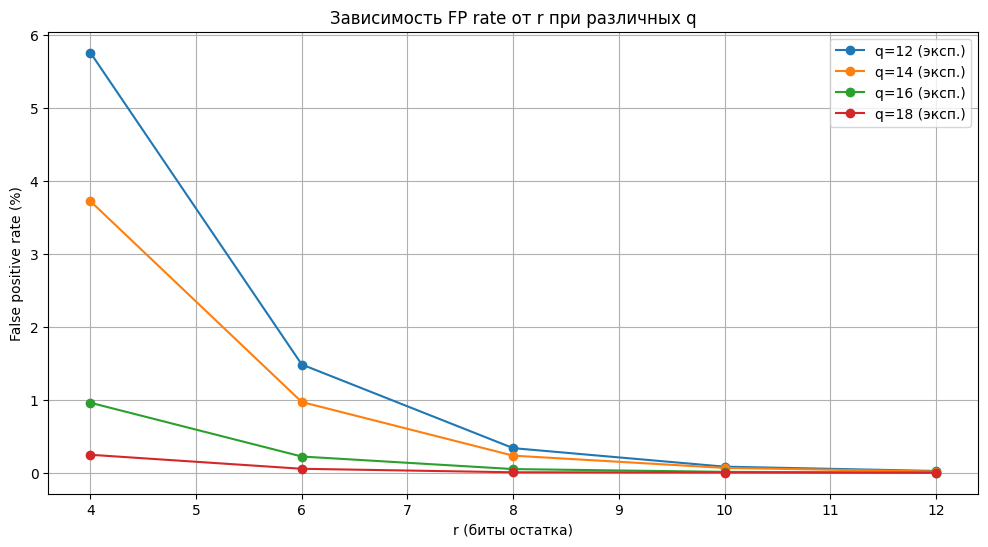

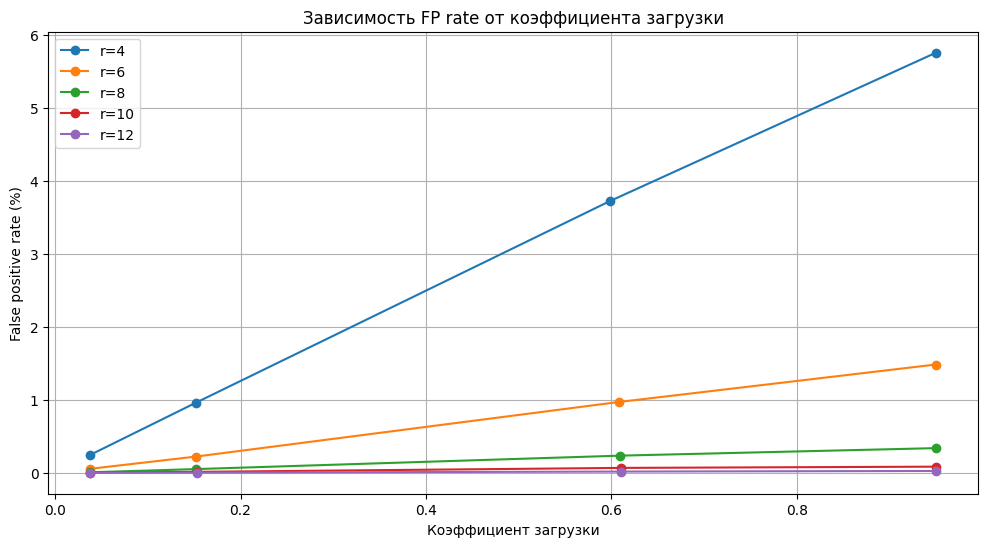

In [ ]:
def analyze_parameters():
    num_elements = 10000
    num_tests = 100000
    
    # Варианты параметров
    q_values = [12, 14, 16, 18]
    r_values = [4, 6, 8, 10, 12]
    
    results = []
    
    for q in q_values:
        for r in r_values:
            print(f"\nTesting q={q}, r={r}")
            try:
                fp_exp, load = test_false_positive_rate(q, r, num_elements, num_tests)
                results.append({
                    'q': q,
                    'r': r,
                    'fp_exp': fp_exp,
                    'load': load
                })
            except Exception as e:
                print(f"Error with q={q}, r={r}: {str(e)}")
                continue
    
    return results

def plot_results(results):
    # График FP rate от r при разных q
    plt.figure(figsize=(12, 6))
    for q in sorted({r['q'] for r in results}):
        subset = [r for r in results if r['q'] == q]
        x = [r['r'] for r in subset]
        y_exp = [r['fp_exp'] for r in subset]
        
        plt.plot(x, y_exp, 'o-', label=f'q={q} (эксп.)')
    
    plt.xlabel('r (биты остатка)')
    plt.ylabel('False positive rate (%)')
    plt.title('Зависимость FP rate от r при различных q')
    plt.legend()
    plt.grid()
    plt.show()
    
    # График FP rate от коэффициента загрузки
    plt.figure(figsize=(12, 6))
    for r_fix in sorted({r['r'] for r in results}):
        subset = [r for r in results if r['r'] == r_fix]
        x = [r['load'] for r in subset]
        y_exp = [r['fp_exp'] for r in subset]
        
        plt.plot(x, y_exp, 'o-', label=f'r={r_fix}')
    
    plt.xlabel('Коэффициент загрузки')
    plt.ylabel('False positive rate (%)')
    plt.title('Зависимость FP rate от коэффициента загрузки')
    plt.legend()
    plt.grid()
    plt.show()

results = analyze_parameters()
plot_results(results)